<a href="https://colab.research.google.com/github/jessicabrooke10/Senior-Design-Project/blob/Mason-Model/prophet_boolschedule_dataprep_singleserver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# Import necessary libraries
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from datetime import timedelta

In [21]:
def prepare_cpu_data(file_path, host_name=None):
    df = pd.read_csv(file_path)
    df = df.fillna(0)

    # Calculate the average CPU usage for each server
    average_cpu = df.groupby('host')['CPU_95th_Perc'].mean().reset_index()

    # Find inactives and filter them out
    inactive_servers = average_cpu[average_cpu['CPU_95th_Perc'] == 0]['host'].unique()
    active_data = df[~df['host'].isin(inactive_servers)]

    # Check if a host_name is given
    if host_name is not None:
        # Filter the data for the specified host
        active_data = active_data[active_data['host'] == host_name]

    # If host_name is not given, aggregate CPU usage by time for all active servers
    if host_name is None:
        data = active_data.groupby('_time')['CPU_95th_Perc'].mean().reset_index()
    else:
        # If a single server is specified, there's no need to aggregate
        data = active_data[['_time', 'CPU_95th_Perc']]

    # Prepare the DataFrame
    data.columns = ['ds', 'y']

    # Convert the 'ds' column to datetime format and remove timezone info
    data.loc[:, 'ds'] = pd.to_datetime(data['ds']).dt.tz_localize(None)

    return data

file_path = 'exportforuconn.csv'
aggregated_data = prepare_cpu_data(file_path, host_name='153lt8728s.example.com')
print(aggregated_data)

                         ds      y
62      2023-09-17 10:25:00  27.91
146     2023-09-17 10:45:00   0.00
192     2023-09-17 10:55:00  28.41
258     2023-09-17 11:05:00  49.94
291     2023-09-17 11:10:00   0.00
...                     ...    ...
780181  2023-10-17 19:05:00  72.94
780315  2023-10-17 19:10:00  70.64
780449  2023-10-17 19:15:00  69.36
780583  2023-10-17 19:20:00  80.57
780717  2023-10-17 19:25:00  79.63

[8735 rows x 2 columns]


In [14]:
# Initialize the Prophet model
model = Prophet()

# Fit the model with the data
model.fit(aggregated_data)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfabdg533/7bxyfe84.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfabdg533/8gdecqmq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22627', 'data', 'file=/tmp/tmpfabdg533/7bxyfe84.json', 'init=/tmp/tmpfabdg533/8gdecqmq.json', 'output', 'file=/tmp/tmpfabdg533/prophet_modelb3r1g32x/prophet_model-20240422201915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:19:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:19:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [23]:
# Create a future dataframe for the next 24 hours at 5-minute intervals -- 288 periods = (24hrs * 60 min/hr) / (5 mininterval)
future = model.make_future_dataframe(periods=288, freq='5min')

# Make Prediction
forecast = model.predict(future)

In [25]:
# Filter forecast for future predictions only
last_history_time = aggregated_data['ds'].max()
future_forecast = forecast[forecast['ds'] > last_history_time]

# Calculate the median of the future CPU usage
median_cpu_usage = future_forecast['yhat'].median()

# Create a new DataFrame for the next 24 hours at 30-minute intervals
time_range = pd.date_range(start=last_history_time, periods=48, freq='30min')
server_on_off_df = pd.DataFrame(time_range, columns=['Time'])
server_on_off_df['Server'] = False  # Initialize column with False

# For each time in the new DataFrame, determine if we're turning servers on or off based on the median
for index, row in server_on_off_df.iterrows():
    # Find the closest time in the future_forecast and its predicted value
    closest_time = future_forecast.iloc[(future_forecast['ds'] - row['Time']).abs().argsort()[:1]]
    if closest_time['yhat'].values[0] > median_cpu_usage:
        server_on_off_df.at[index, 'Server'] = True

# Display the new DataFrame
print(server_on_off_df)

                  Time  Server
0  2023-10-17 19:25:00    True
1  2023-10-17 19:55:00    True
2  2023-10-17 20:25:00    True
3  2023-10-17 20:55:00    True
4  2023-10-17 21:25:00    True
5  2023-10-17 21:55:00    True
6  2023-10-17 22:25:00    True
7  2023-10-17 22:55:00    True
8  2023-10-17 23:25:00    True
9  2023-10-17 23:55:00    True
10 2023-10-18 00:25:00    True
11 2023-10-18 00:55:00    True
12 2023-10-18 01:25:00    True
13 2023-10-18 01:55:00    True
14 2023-10-18 02:25:00   False
15 2023-10-18 02:55:00   False
16 2023-10-18 03:25:00    True
17 2023-10-18 03:55:00    True
18 2023-10-18 04:25:00   False
19 2023-10-18 04:55:00   False
20 2023-10-18 05:25:00   False
21 2023-10-18 05:55:00   False
22 2023-10-18 06:25:00   False
23 2023-10-18 06:55:00   False
24 2023-10-18 07:25:00   False
25 2023-10-18 07:55:00   False
26 2023-10-18 08:25:00   False
27 2023-10-18 08:55:00   False
28 2023-10-18 09:25:00   False
29 2023-10-18 09:55:00   False
30 2023-10-18 10:25:00   False
31 2023-

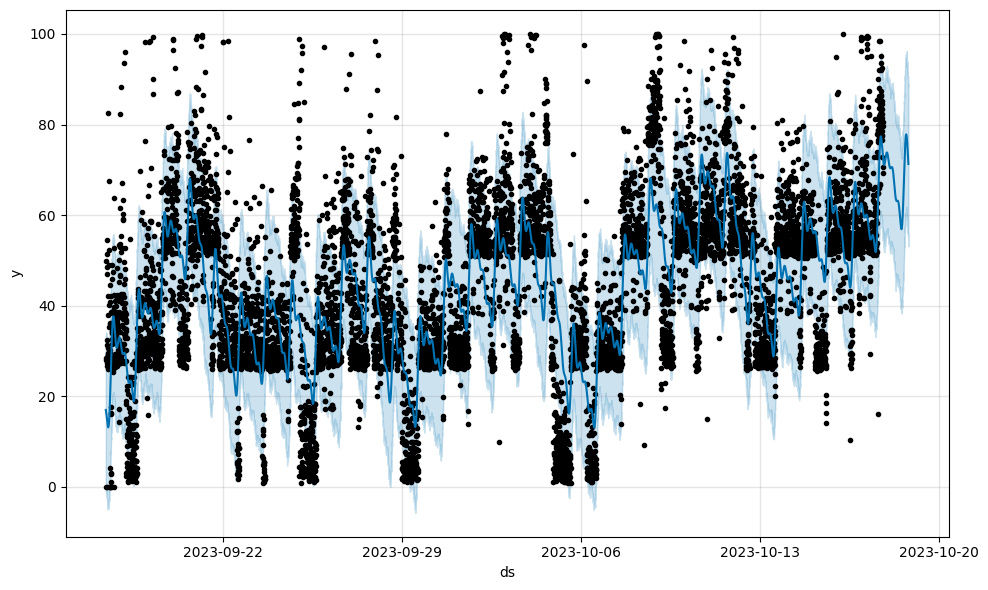

In [17]:
# Plot the forecast
fig1 = model.plot(forecast)
plt.show()

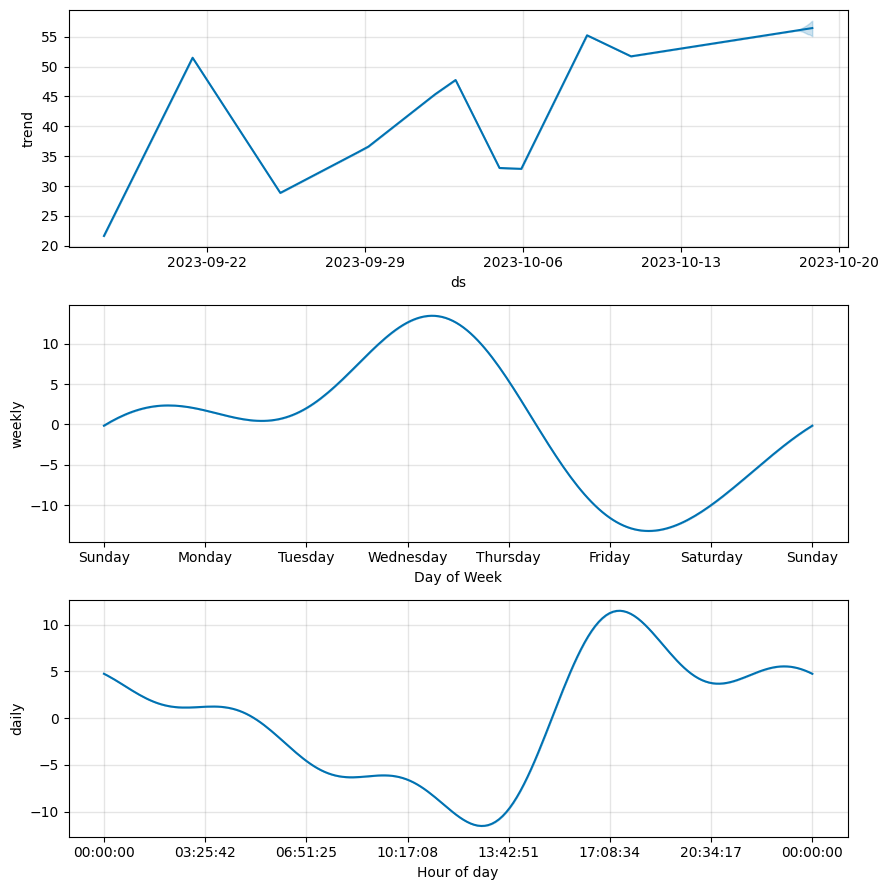

In [26]:
# Plot components
fig2 = model.plot_components(forecast)
plt.show()